#ToDO

    1. Clean up mapper function 
    2. TODO: Check the i,j indexing and make sure that you understand 
        why they are included angle calculations !
    
##Ideas for cylindrical map validation

    Integrate two "equal area" regions, check if the areas are about the same
    Problem: the image has no direct spatial informaion 
    Potential Solution: derive spatial numbers for two regions BUT HOW ??

In [41]:
#import astropy
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd
#import seaborn as sns
%matplotlib inline

###Import MDI Image

In [2]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/fd_M_96m_01d.6543.0000.fits"

In [3]:
hdulist = fits.open(path)

In [4]:
# refer to hud number 0 
hdu = hdulist[0]

In [5]:
hdu.header

SIMPLE  =                    T / file conforms with FITS standard; SOI V6R1B0   
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT Data from the Solar Oscillations Investigation / Michelson Doppler      
COMMENT   Imager (SOI/MDI) on the Solar and Heliospheric Observatory (SOHO).    
COMMENT For information on data rights, keyword definitions, and up-to-date     
COMMENT   reports on known problems and data quality, see:                      
COMMENT   http://soi.stanford.edu/data.html                                     
HISTORY created by mdical Mon Dec  6 15:59:51 2010                              
HISTORY created by MDI_image_reconstructor Thu Dec  9 10:03:53 2010             
HISTORY An MDI magnetogram z

###Import HMI Image

In [15]:
path2 = "/Users/Alexander/NASA/NASA_Sample_Data/HMI.m2010.12.01_00.00.00.fits"

In [16]:
hdulist2 = fits.open(path2)

In [17]:
# meta-data of image 
hdulist2.info()

Filename: /Users/Alexander/NASA/NASA_Sample_Data/HMI.m2010.12.01_00.00.00.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       8   ()              
1                ImageHDU       100   (4096, 4096)   int32 (rescales to float64)   


In [18]:
# refer to hud number 1
hdu_2 = hdulist2[1]

In [19]:
hdu_2.header

 [astropy.io.fits.verify]



XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
DATE    = '2010-12-11T02:56:52'                                                 
DATE-OBS= '2010-11-30T23:58:11.60'                                              
TELESCOP= 'SDO/HMI'                                                             
INSTRUME= 'HMI_SIDE1'                                                           
WAVELNTH= 6173.0                                                                
CAMERA  =                   

###Clean Data

In [6]:
df = pd.DataFrame(hdu.data)
#df2 =  pd.DataFrame(hdu_2.data)

df.fillna(value=0,inplace=True)
#df2.fillna(value=0,inplace=True)

clean_data = df.values
#clean_data_2 = df2.values

###Import parameters from MDI Image Header

In [7]:
def get_header_params_MDI(header):
    '''Gets parameters from MDI image file that are required to 
       perform an Equal Area Map Cylindrical Projection 
       INPUT:  Image header
       OUTPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
    '''
    xCen = header["X0"]
    yCen = header["Y0"]
    s0 = header["OBS_R0"]
    nx = header["NAXIS1"]
    pixsize = header["FD_SCALE"]
    p0 = header["P_ANGLE"]
    b0 =header["OBS_B0"]
    r0 = s0/pixsize
    yCen = xCen + 0.5
    yCen = yCen + 0.5
    p0 = p0 - 0.21
    return xCen,yCen,s0,nx,pixsize,p0,b0, r0

###Import parameters from HMI Image Header

In [8]:
def get_header_params_HMI(header):
    '''Gets parameters from HMI image file that are required to 
       perform an Equal Area Map Cylindrical Projection 
       INPUT:  Image header
       OUTPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
    '''
    xCen = header["CRPIX1"]
    yCen = header["CRPIX2"]
    s0 = header["RSUN_OBS"]
    nx = header["NAXIS1"]
    pixsize = header["CDELT1"]
    p0 = header["CROTA2"]
    b0 =header["CRLT_OBS"]
    r0 = s0/pixsize
    
    # Shift origin from center of pixel to lower left of pixel
    yCen = xCen + 0.5
    yCen = yCen + 0.5
    # Correct for the misalignment of the CCD with the satellite
    p0 = -p0
    return xCen,yCen,s0,nx,pixsize,p0,b0, r0

In [9]:
def map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, v, dim = 4):
    '''Performs an Equal Area Map Cylindrical Projection 
       INPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
       OUTPUT: transformed data as an array
    '''
    
   
    vmap = np.empty([nx,nx]) # create array for transformed data
    wx = np.empty([dim,dim])
    wy = np.empty([dim,dim])
    data = np.empty([dim,dim])
    
    pihalf=pi/2.             # pi/2
    rsq=r0*r0                # radius of solar disk squared 
    rsqtest= (r0-2.)*(r0-2.) # exclude the two pixels at the limb
    sr=s0*pi/(180.*3600.)    # convert semi-diameter units from arcseconds to radians
    sins0=sin(sr)            # sin component of semi-diameter
    coss0=cos(sr)            # cos component of semi-diameter
    radsol=r0*coss0          # solar radius 

    # Trignometric factors for position angle of rotation axis (wrt vertical axis of image)
    cosp0=cos(p0*pi/180.)
    sinp0=sin(p0*pi/180.)

    # Trignometric factors for tilt angle of rotation axis (latitude at disk center), wrt horizontal axis of image
    cosb0=cos(b0*pi/180.)
    sinb0=sin(b0*pi/180.)

    # Maximum z position for image pixels to be visible
    zpmin=radsol*sins0

    # Heliographic coordinate step sizes
    dcosTheta=2./nx
    dphi=pi/nx

    pihalf=pi/2.             # pi/2
    rsq=r0*r0                # radius of solar disk squared 
    rsqtest= (r0-2.)*(r0-2.) # exclude the two pixels at the limb
    sr=s0*pi/(180.*3600.)    # convert semi-diameter units from arcseconds to radians
    sins0=sin(sr)            # sin component of semi-diameter
    coss0=cos(sr)            # cos component of semi-diameter
    radsol=r0*coss0          # solar radius 

    # Trignometric factors for position angle of rotation axis (wrt vertical axis of image)
    cosp0=cos(p0*pi/180.)
    sinp0=sin(p0*pi/180.)

    # Trignometric factors for tilt angle of rotation axis (latitude at disk center), wrt horizontal axis of image
    cosb0=cos(b0*pi/180.)
    sinb0=sin(b0*pi/180.)

    # Maximum z position for image pixels to be visible
    zpmin=radsol*sins0

    # Heliographic coordinate step sizes
    dcosTheta=2./nx
    dphi=pi/nx
    
    
    # Latitude at pixel center

    # South pole is at bottom edge of bottom row of pixels
    # North pole is at top edge of top row of pixels

    # TODO: Check the i,j indexing and make sure that you understand 
    #       why they are included angle calculations !
    for j in xrange(1, nx + 1): # rows, range [1,1024]
        cosTheta = -1.0 + (j-0.5) * dcosTheta
        sinb = cosTheta
        cosb = sqrt(1. - sinb*sinb)

        for i in xrange(1, nx + 1): # cols, range [1,1024]

            # Longitude at pixel center
            # Central meridian goes through the leading edge of pixel column at i=nx/2

            phi=(i-0.5)*dphi-pihalf
            cosphi=cos(phi)
            sinphi=sin(phi)

            # Heliographic cartesian coordinates
            xs=radsol*sinphi*cosb
            ys=radsol*sinb
            zs=radsol*cosphi*cosb

            # Rotated Heliographic cartesian coordinates with B-angle
            xb=xs
            yb=cosb0*ys - sinb0*zs
            zb=cosb0*zs + sinb0*ys

            # Rotated Heliographic cartesian coordinates with CCW P-angle
            xp=cosp0*xb - sinp0*yb
            yp=cosp0*yb + sinp0*xb
            zp=zb

            # Test for visibility (skip if point is behind limb)
            if (zp > zpmin):
                # Image coordinate transformation for perspective effects
                rhop=sqrt(xp*xp + yp*yp)
                thetap=0.0

                if (rhop >  0.):
                    thetap=atan2(yp,xp)

                rhoi=rhop*(1.0 + zp/(radsol/sins0 - zp))
                x=rhoi*cos(thetap)
                y=rhoi*sin(thetap)

                xi=xCen + x
                yi=yCen + y

                radsq=x*x + y*y

                # Exclude pixels near the limb
                if (radsq < rsqtest):
                    ix=int(xi)
                    iy=int(yi)
                    dx=xi-ix
                    dy=yi-iy


                    # Bi-cubic interpolation from adjacent points.
                    #data = v[ix-2:ix+2, iy-2:iy+2]
                    #      v[rows, cols]
                    data = v[iy-2:iy+2, ix-2:ix+2]

                    # Weights for cubic interpolation
                    dx2=dx*dx
                    dx3=dx*dx2
                    dy2=dy*dy
                    dy3=dy*dy2

                    for ind in xrange(0,4):
                        wx[ind, 0:4] =  [-0.5*dx + dx2 - 0.5*dx3, \
                                         1.0 - 2.5*dx2 + 1.5*dx3,\
                                         0.5*dx + 2.*dx2 - 1.5*dx3,\
                                                -0.5*dx2 + 0.5*dx3]

                        wy[0:4, ind] = [-0.5*dy + dy2 - 0.5*dy3,\
                                        1.0 - 2.5*dy2 + 1.5*dy3,\
                                        0.5*dy + 2.*dy2 - 1.5*dy3,\
                                               -0.5*dy2 + 0.5*dy3]

                    weight = wx*wy # Broadcasting a row with a col 
                    #vmap[i,j]= np.sum(weight*data)
                    vmap[j,i]= np.sum(weight*data)
    return vmap

### Transformation (MDI)

In [10]:
# extract parameters from header
xCen,yCen,s0,nx,pixsize,p0,b0, r0 = get_header_params_MDI(hdu.header)

In [11]:
# transform data into cylindrical equal area map
trans_data = map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data)

### Transformation (HMI)

In [24]:
# extract parameters from header
xCen_2,yCen_2,s0_2,nx_2,pixsize_2,p0_2,b0_2, r0_2 = get_header_params_HMI(hdu_2.header)

In [25]:
# transform data into cylindrical equal area map
trans_data_2 = map_disk_cylindric(xCen_2,yCen_2,s0_2,nx_2,pixsize_2,p0_2,b0_2, r0_2, clean_data_2)

###Original (MDI)

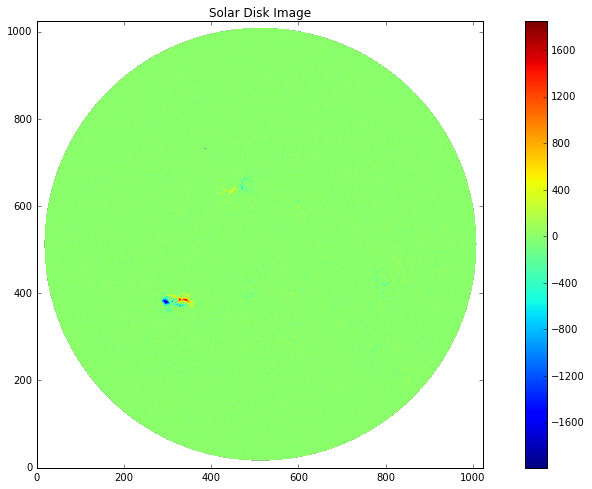

In [12]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(clean_data == 0.0, clean_data)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((280,380))
# plt.ylim((350,400))
plt.colorbar()

plt.show()

###Equal Area Cylindrical Transformation (MDI)

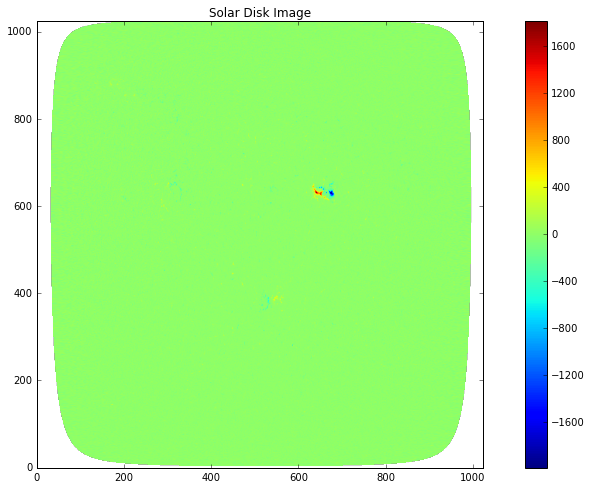

In [13]:
plt.figure(figsize = (15,8));
a2 = np.ma.masked_where(trans_data == 0.0, trans_data)
plt.imshow(a2, origin='lower')
plt.title("Solar Disk Image")
# plt.xlim((600,800))
# plt.ylim((550,700))
plt.colorbar()

plt.show()

###Original (HMI)

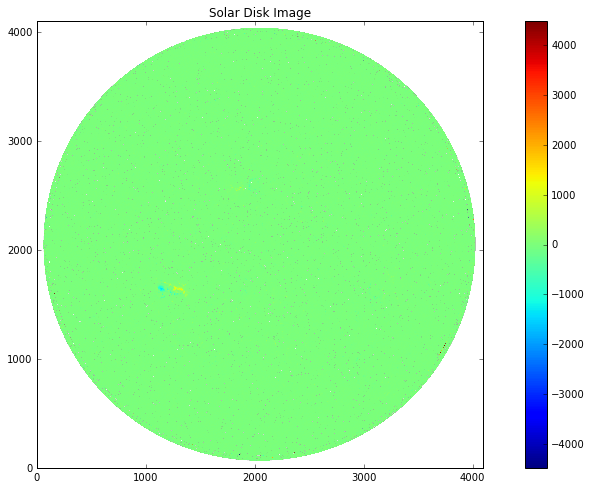

In [33]:
plt.figure(figsize = (15,8));
b = np.ma.masked_where(clean_data_2 == 0.0, clean_data_2)
plt.imshow(b, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((280,380))
# plt.ylim((350,400))
plt.colorbar()

plt.show()

###Equal Area Cylindrical Transformation (HMI)

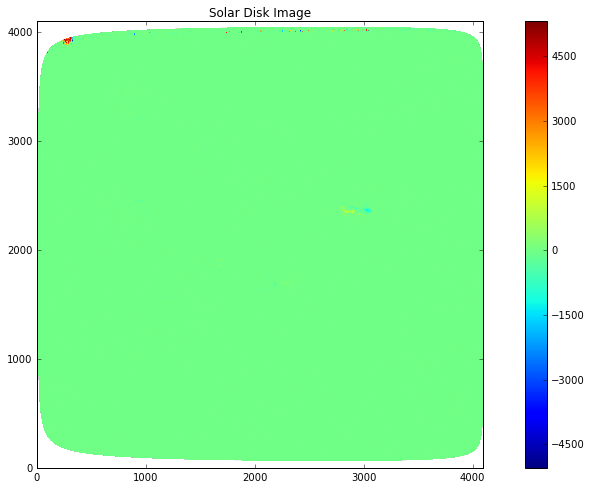

In [34]:
plt.figure(figsize = (15,8));
b2 = np.ma.masked_where(trans_data_2 == 0.0, trans_data_2)
plt.imshow(b2, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((280,380))
# plt.ylim((350,400))
plt.colorbar()

plt.show()

##Find Active Regions of Magnetic Fields

1. Take abs of data to identify active regions, the signs doesn't matter
2. Smooth the data with smoothing Kernal
    Will have to explore different types of kernels (shape and sizes) for best results
3. Apply thresholding, will have to explore threshold values around 150 G

Smoothing will need to be down twice
    Once to identify the active regions
    Once to expand the active regions and include the boarding weak fields 
    
4. Apply Convolution with Fourier Transforms 

We are making an Active Region Map

    0 -> not active region
    1 -> active region

In [14]:
from astropy.convolution import convolve_fft, convolve

In [15]:
import astropy.convolution

In [16]:
# Take abs of data to identify active regions, the signs doesn't matter
data_abs = np.abs(trans_data)

###2D Smoothing Kernels

In [21]:
gauss = astropy.convolution.Gaussian2DKernel(stddev=10)

In [31]:
param = 10

In [32]:
box = astropy.convolution.Box2DKernel(width=param) # width = pixels?

In [33]:
AiryDisk = astropy.convolution.AiryDisk2DKernel(radius = param) # radius = pixels?

In [34]:
mex = astropy.convolution.MexicanHat2DKernel(width=param) # width = stddev?

In [35]:

trap = astropy.convolution.TrapezoidDisk2DKernel(param) # width = what?

###Convolutions

In [22]:
gauss_data = convolve_fft(data_abs, gauss)

In [37]:
box_data = convolve_fft(data_abs, box)

In [38]:
AiryDisk_data = convolve_fft(data_abs, AiryDisk)

In [39]:
mex_data = convolve_fft(data_abs, mex)

In [40]:
trap_data = convolve_fft(data_abs, trap)

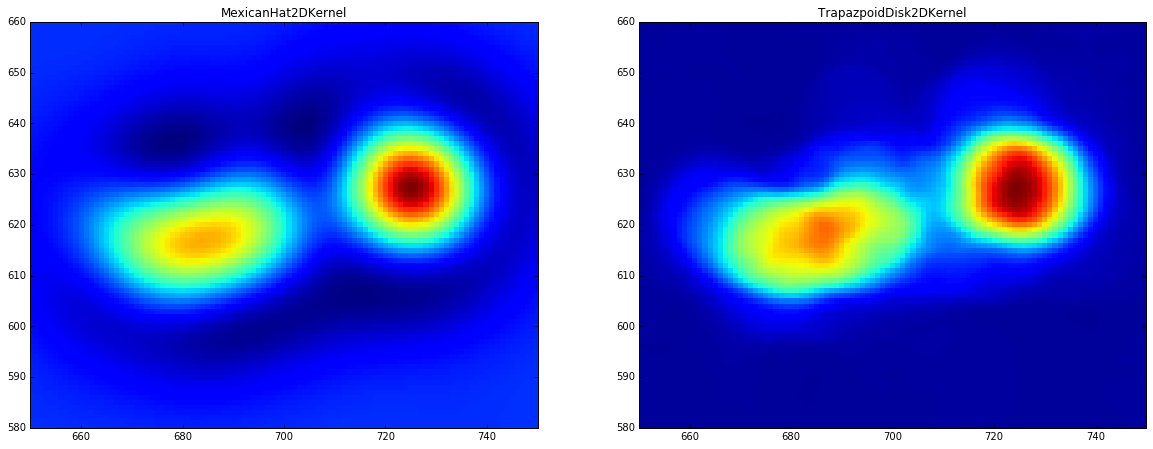

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('MexicanHat2DKernel')
ax2.set_title('TrapazpoidDisk2DKernel')
ax1.set_xlim([650,750])
ax1.set_ylim([580,660])
ax2.set_xlim([650,750])
ax2.set_ylim([580,660])
ax1.imshow(mex_data, interpolation='none', origin='lower');
ax2.imshow(trap_data, interpolation='none', origin='lower');

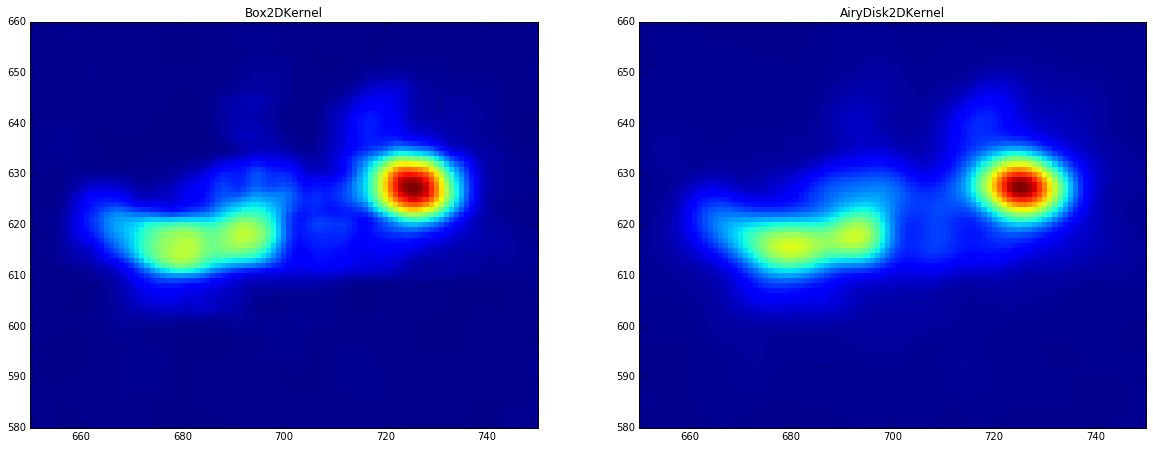

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('Box2DKernel')
ax2.set_title('AiryDisk2DKernel')
ax1.set_xlim([650,750])
ax1.set_ylim([580,660])
ax2.set_xlim([650,750])
ax2.set_ylim([580,660])
ax1.imshow(box_data, interpolation='none', origin='lower');
ax2.imshow(AiryDisk_data, interpolation='none', origin='lower');

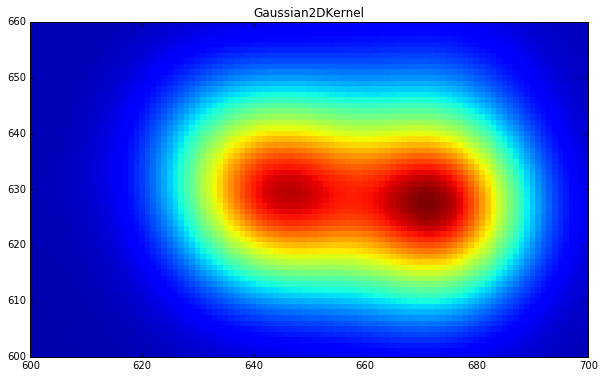

In [30]:
plt.figure(figsize = (10,10));
plt.imshow(gauss_data, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel")
#plt.colorbar()
plt.xlim((600,700))
plt.ylim((600,660))
plt.show()

##The Gaussian Kernel seems most promising
Let's see the effect of changing the Standard Deviaton

In [31]:
start = time()
smoothing_one = convolve_fft(data_abs, gauss)
#smoothing_two = convolve_fft(smoothing_one,gauss)
end = time()
print "Time Elapsed {:.3}".format(end - start)

Time Elapsed 1.34


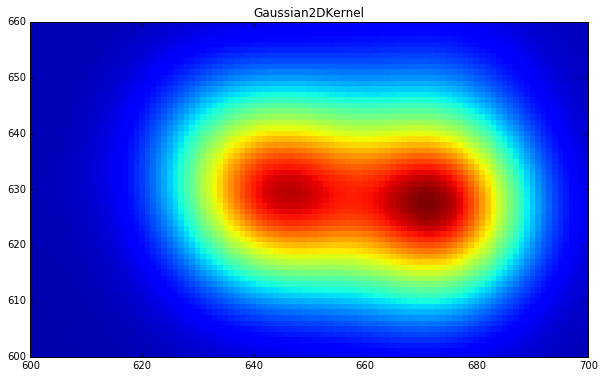

In [34]:
plt.figure(figsize = (10,10));
plt.imshow(smoothing_one, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel")
plt.xlim((600,700))
plt.ylim((600,660))
#plt.colorbar()
plt.show()

A std of 5 seems to preserve enough independent stucture of each sunspot while also caturing the relationship between them. 

###Create Active Region Mask
    In Mask:
        0 --> Not Active
        1 --> Active
    Mask will filter original image of magnetic fields less than some value, k. 
    The resulting image will only have the active region remaining. 

In [35]:
k = 130 # <-- use as offical cut off value !
smoothing_one[smoothing_one < k] = 0.
smoothing_one[smoothing_one >= k] = 1 

In [36]:
# filter original image with active region map 
test = np.where(smoothing_one !=0.0 , trans_data, smoothing_one)

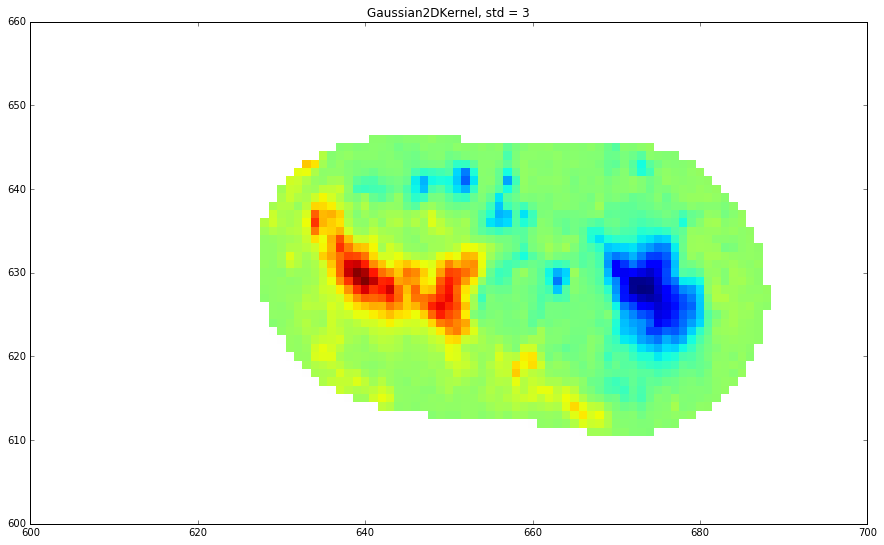

In [38]:
plt.figure(figsize = (15,15));
test_plot  = np.ma.masked_where(test == 0.0, test)
plt.imshow(test_plot, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 3")
#plt.colorbar()
plt.xlim((600,700))
plt.ylim((600,660))
plt.show()

###Map to 2D Cartisian Coordinates (i.e. drop the zeros)

In [44]:
test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [42]:
np.unique(smoothing_one)

array([ 0.,  1.])

In [75]:
x_coords = []
y_coords = []
z_coords = []
coords = []
for i, row in enumerate(np.abs(test)):
    for j, col in enumerate(row):
        if smoothing_one[i,j] == 1:
            x_coords.append(i)
            y_coords.append(j)
            z_coords.append(col)
            coords.append([i,j,col])

In [ ]:
import plotly.plotly as py

In [107]:
scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x =x_coords, y = y_coords, z = z_coords,
    marker = dict( size=2, color="rgb(23, 190, 207)" )
)
clusters = dict(
    alphahull = 7,
    name = "y",
    opacity = 0.1,
    type = "mesh3d",    
    x = x_coords, y = y_coords, z = z_coords
)
layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
url = py.iplot(fig, filename='3d point clustering')

In [108]:
url

In [76]:
print x_coords[0:5]
print y_coords[0:5]
print z_coords[0:5]

[611, 611, 611, 611, 611]
[667, 668, 669, 670, 671]
[89.37754263777515, 87.088426277064386, 70.53422657920818, 0.66698190841754457, 3.3591835288546537]


In [77]:
# HDBSCAN doesn't seem to be working out very well
import hdbscan

In [120]:
cluster = hdbscan.HDBSCAN(min_cluster_size=19)

In [121]:
model = cluster.fit(coords)

In [122]:
np.unique(model.labels_)

array([-1,  0,  1,  2])

In [123]:
len(model.labels_)

1804

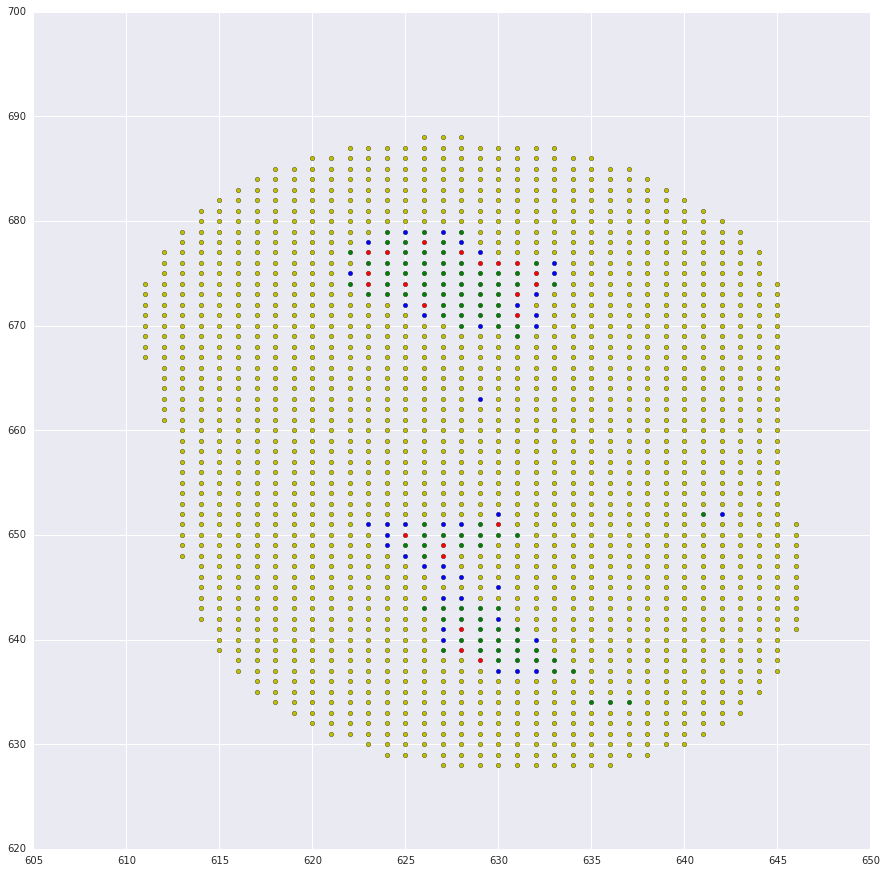

In [127]:
plt.figure(figsize = (15,15));
for x, y, label in zip(x_coords, y_coords,model.labels_ ):
    if label == 0:
        plt.scatter(x,y, c="b", marker='o');
    elif label ==1:
        plt.scatter(x,y, c="r",marker='o');
    elif label == 2: 
        plt.scatter(x,y, c="y",marker='o');
    else:
        plt.scatter(x,y, c="g",marker='o');

##K-Means

In [140]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [146]:
k = 2
k_model = KMeans(n_clusters=k, n_jobs = -1)

In [147]:
model_predict = k_model.fit_predict(coords)

In [151]:
k_model.inertia_

62341622.302370757

In [148]:
silhouette_score(np.array(coords), model_predict)

0.76503071171371639

In [152]:
k_model.cluster_centers_

array([[  629.00328515,   657.84362681,   145.05504617],
       [  629.07801418,   658.56737589,  1029.46566458]])

In [154]:
KK = 10

In [160]:
##### cluster data into K=1..10 clusters #####
K_MAX = 10
KK = range(1,K_MAX+1)

KM = [KMeans(coords,k) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares

TypeError: 'KMeans' object is not iterable

##Use Active Mask to Identify Distinct Sunspots

###Peak Detection Code 
    https://gist.github.com/endolith/250860

In [16]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [17]:
from matplotlib.pyplot import plot, scatter, show

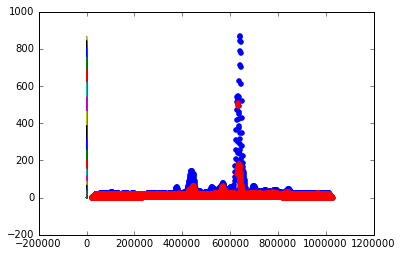

In [43]:
series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
maxtab, mintab = peakdet(smoothing_two.flatten(),.3)
plot(smoothing_two)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()

In [48]:
print maxtab.shape
print mintab.shape

(34347, 2)
(34346, 2)


In [45]:
import scipy.fftpack

In [46]:
fft_result = scipy.fftpack.rfft(data_abs)

In [47]:
plt.figure(figsize = (15,10));
plt.plot(test, 'b');

NameError: name 'test' is not defined

##HDBSCAN

Model needs to be tuned to 'see' that there are 2 sunspots clusters, not 3. 
By looking at the contour maps, we see that there are 3 highly dense regions, 
this must be what hdbscan sees as the 3 clusters -- though we want it to find 2 clusters. 

Potential Solutions: maybe we can help the model 'see' the polarity of the field,
this may help to distinguish distinct sunspots (i.e. even though there are 2 highly dense regions near each other, if they have the same polarity, then they are a single sunspot, and not 2)

In [48]:
import hdbscan

In [247]:
hdb_result = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100, gen_min_span_tree=True)

In [248]:
# active map filtered data
hdb_result = hdb.fit(smoothing_two)

In [249]:
# original disk data
hdb_result = hdb.fit(trans_data)

In [250]:
hdb_result.condensed_tree_.plot?

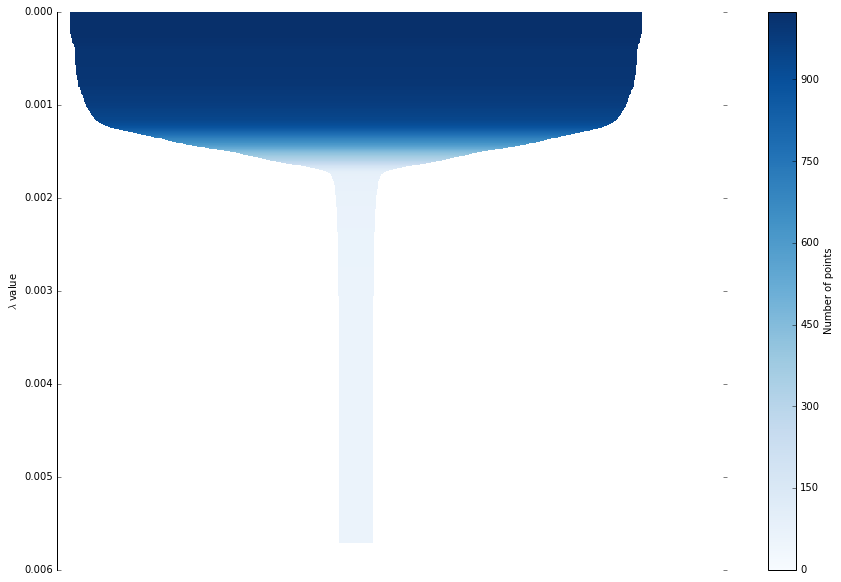

In [251]:
plt.figure(figsize = (15,10));
hdb_result.condensed_tree_.plot( label_clusters=True);

In [252]:
hdb_data = hdb_result.condensed_tree_.get_plot_data()

In [253]:
hdb_data.keys()

['cluster_bounds',
 'line_xs',
 'bar_tops',
 'bar_widths',
 'line_ys',
 'bar_centers',
 'bar_bottoms']

In [256]:
np.unique( hdb_result.labels_)

array([-1,  0,  1])

In [255]:
test.shape

(1024, 1024)

In [558]:
dirty_prob = pd.DataFrame(hdb_result.probabilities_)

dirty_prob.fillna(value=0,inplace=True)

clean_prob = dirty_prob.values

In [570]:
hdb_result.probabilities_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [98]:
cluster_colors = [sns.color_palette(desat=sat)[col] 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(hdb_result.labels_, hdb_result.probabilities_)]
plt.plot(test, c=cluster_colors);

NameError: name 'hdb_result' is not defined